## CW generation.


In [1]:
! pip install pmcx
! pip install numpy pmcx jdata bjdata matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
import os
import pmcx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import math
import io

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Path to your folder containing the .py script
folder_path = '/content/drive/MyDrive/MCX_data'

# Add to sys.path so you can import the script
if folder_path not in sys.path:
    sys.path.append(folder_path)
from FD_msNIRS import mcx_simulation as ms
from FD_msNIRS import extract_freq as ef

In [4]:
!ls '/content/drive/MyDrive/MCX_data'

2_L_30_mu_as_df.csv	       EC.xlsx	     __pycache__
2_L_30_mu_s_primes_df.csv.csv  FD_msNIRS.py


In [5]:
pmcx.gpuinfo()

[{'name': 'NVIDIA A100-SXM4-40GB',
  'id': 1,
  'devcount': 1,
  'major': 8,
  'minor': 0,
  'globalmem': 42474471424,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1410000,
  'sm': 108,
  'core': 6912,
  'autoblock': 64,
  'autothread': 442368,
  'maxgate': 0}]

### concentration -> Ua and Us

### Ua

In [6]:
HbO2_mean = 60  # microMolar
Hb_mean = 25    # microMolar
CCO_mean = 8.5    # microMolar
concentrations_true = np.array([HbO2_mean, Hb_mean, CCO_mean])
C_true = concentrations_true / 1e6

In [7]:
lambdas = [
    688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699,
    700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711,
    712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723,
    724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735,
    736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747,
    748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759,
    760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771,
    772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783
]

In [8]:
extinction_coeffs = pd.read_excel(folder_path + "/EC.xlsx")
extinction_coeffs_filtered = extinction_coeffs[extinction_coeffs['Lambda'].isin(lambdas)]

In [9]:
E3 = extinction_coeffs_filtered[['HbO2', 'Hb','CCO']].values
E3 = E3 * math.log(10)
E3.shape

(96, 3)

In [10]:
mu_a = np.dot(C_true, E3.T)

In [11]:
mu_a

array([0.22341221, 0.22051578, 0.21770322, 0.21501437, 0.21259049,
       0.21026027, 0.20794563, 0.20579087, 0.20378775, 0.20180034,
       0.19997682, 0.19827318, 0.19659261, 0.19491623, 0.19345383,
       0.19200006, 0.19056141, 0.18921723, 0.18794832, 0.1866534 ,
       0.18533305, 0.18409817, 0.18290575, 0.181822  , 0.18075591,
       0.17958424, 0.17839838, 0.17732134, 0.17631968, 0.17533901,
       0.17437217, 0.1736145 , 0.17284068, 0.17213815, 0.17152851,
       0.17111655, 0.17072434, 0.17044492, 0.17032035, 0.17024409,
       0.1701982 , 0.17044819, 0.17077039, 0.17117139, 0.17171898,
       0.17245259, 0.17319171, 0.17399056, 0.17516024, 0.17633487,
       0.17755016, 0.17903441, 0.18064391, 0.18231321, 0.1840811 ,
       0.18608362, 0.1881085 , 0.19007672, 0.19229228, 0.19452839,
       0.19677867, 0.19909277, 0.20141496, 0.20380424, 0.2061338 ,
       0.20825436, 0.21037124, 0.21244112, 0.21396819, 0.21529705,
       0.21671781, 0.21753985, 0.21809158, 0.21857899, 0.21887

### Us

In [12]:
a = 22
b = 1.2
mu_s_prime = np.array([a * (wavelength / 500) ** (-b) for wavelength in lambdas])

In [13]:
mu_s_prime

array([14.99963048, 14.9735101 , 14.94747298, 14.92151876, 14.89564703,
       14.86985743, 14.84414956, 14.81852307, 14.79297756, 14.76751268,
       14.74212804, 14.71682329, 14.69159805, 14.66645197, 14.64138469,
       14.61639584, 14.59148507, 14.56665202, 14.54189635, 14.5172177 ,
       14.49261572, 14.46809007, 14.44364041, 14.41926638, 14.39496766,
       14.37074391, 14.34659478, 14.32251995, 14.29851908, 14.27459184,
       14.25073791, 14.22695696, 14.20324866, 14.17961269, 14.15604873,
       14.13255646, 14.10913557, 14.08578574, 14.06250666, 14.03929802,
       14.0161595 , 13.99309079, 13.9700916 , 13.94716162, 13.92430055,
       13.90150808, 13.87878392, 13.85612776, 13.83353932, 13.8110183 ,
       13.7885644 , 13.76617734, 13.74385683, 13.72160257, 13.69941429,
       13.6772917 , 13.65523452, 13.63324247, 13.61131526, 13.58945262,
       13.56765428, 13.54591995, 13.52424937, 13.50264226, 13.48109836,
       13.45961739, 13.43819909, 13.41684319, 13.39554943, 13.37

### MCX Simulation using packgae

In [16]:
g=0.85
distance = [2, 2.5, 3.0 ,3.5]
distance_mm = [d * 10 for d in distance]  # mm
distance_data = {d: [] for d in distance_mm}

for sim_idx, (ua_row, us_p_row) in enumerate(zip(mu_a, mu_s_prime)):
    us = us_p_row / (1 - g)
    ua_mm = ua_row / 10
    us_mm = us / 10
    print('ua_mm = ', ua_mm)
    print('us_mm = ', us_mm)
    print(f"\n--- Simulation {sim_idx + 1} ---")

    # -------- Simulation for Multi-Distances --------------
    TPSF_list, time_unit = ms(ua_mm, us_mm, g=0.85, n=1.370, distance=distance_mm, tend=1e-08, devf=1, nphoton=1.2e6)
    [[x[0] * 1.2e6 * 1e-08 ] for x in TPSF_list] # weight/mm2
    for i, d in enumerate(distance_mm):
        distance_data[d].append(TPSF_list[i][0])

ua_mm =  0.022341221001655445
us_mm =  9.999753651461665

--- Simulation 1 ---
nphoton: 1.2e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 1.2e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua_mm =  0.022051577671515176
us_mm =  9.982340063514517

--- Simulation 2 ---
nphoton: 1.2e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 1.2e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua_mm =  0.02177032150757614
us_mm =  9.964981989100465

--- Simulation 3 ---
nphoton: 1.2e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 1.2e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua_mm =  0.021501437133341763
us_mm =  9.947679171175254

--- Simulation 4 ---
nphoton: 1.2e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 1.2e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua_mm =  0.021259048605772466
us_mm =  9.93043135425451

--- Simulation 5 ---
nphoton: 1.2e+06
tstart: 0
tstep: 1e-08
tend: 1e-08

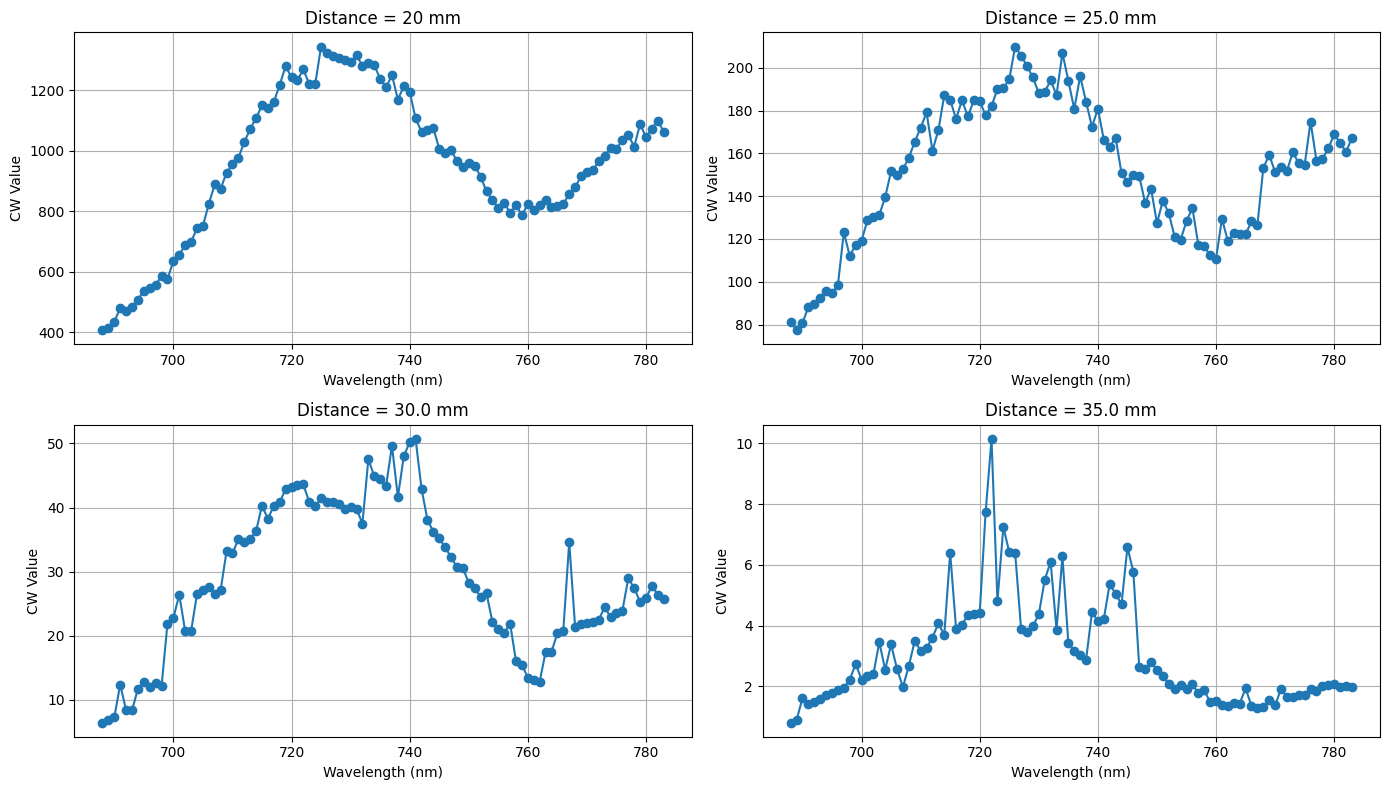

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.flatten()

for idx, (distance, values) in enumerate(distance_data.items()):
    axs[idx].plot(lambdas, values, marker='o')
    axs[idx].set_title(f'Distance = {distance} mm')
    axs[idx].set_xlabel('Wavelength (nm)')
    axs[idx].set_ylabel('CW Value')
    axs[idx].grid(True)

plt.tight_layout()
plt.show()